In [0]:
# %pip install yfinance pandas numpy matplotlib scikit-learn

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, stddev, avg, log, when
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, TimestampType
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime, timedelta

In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")


In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

The code below is only if our API would stop working, but do we need that for the uni project? I was trying to keep as simple code as possible

In [0]:
# try:
#     spark_df = get_alpha_vantage_data(symbol, api_key)
# except:
#     print("Using simulated fallback data")
#     dates = pd.date_range(end=datetime.now(), periods=365*15, freq='B')
#     base = pd.Series(np.linspace(100, 200, len(dates)))
#     price = base + pd.Series(np.random.normal(0, 1, len(dates))).cumsum()
#     fallback = pd.DataFrame({
#         'Date': dates,
#         'open': price * np.random.uniform(0.995, 1.005, len(dates)),
#         'high': price * np.random.uniform(1.000, 1.010, len(dates)),
#         'low': price * np.random.uniform(0.990, 1.000, len(dates)),
#         'close': price,
#         'volume': np.random.randint(5e7, 15e7, len(dates))
#     })
#     spark_df = spark.createDataFrame(fallback)

#### Visualize the data

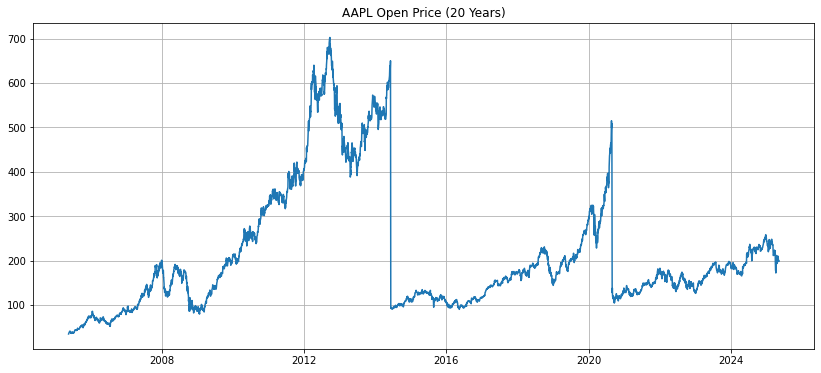

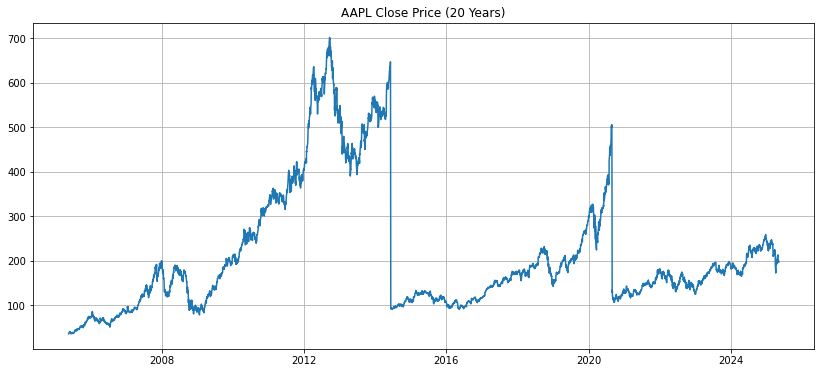

In [0]:
pandas_df = spark_df.select("Date", "close","open").orderBy("Date").toPandas()


plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'])
plt.title('AAPL Open Price (20 Years)')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['close'])
plt.title('AAPL Close Price (20 Years)')
plt.grid(True)
plt.show()

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        #source: https://www.ig.com/en/trading-strategies/apple-stock-split-2020--what-you-need-to-know-230803
        splits = {
            '2005-02-28': 2, # two-for-one stock split on 28 February 2005
            '2014-06-09': 7, #  seven-for-one stock split on 9th of June 2014
            '2020-08-31': 4 #  four-for-one stock split on 31st of August 2020
        }
        for date_str, ratio in splits.items():
            date = pd.Timestamp(date_str)
            mask = df.index < date
            for col in ['open', 'high', 'low', 'close']:
                df.loc[mask, col] = df.loc[mask, col] / ratio
            df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * ratio

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

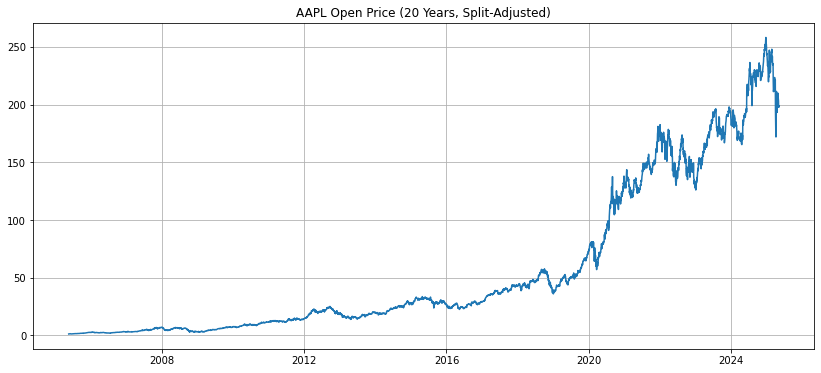

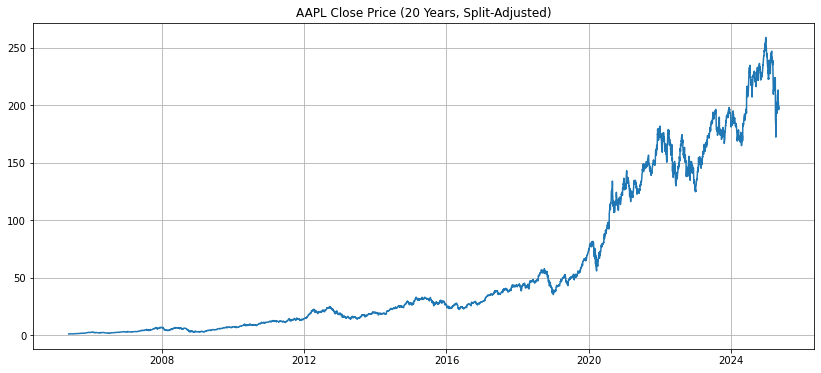

In [0]:
pandas_df = spark_df.select("Date", "close","open").orderBy("Date").toPandas()


plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'])
plt.title('AAPL Open Price (20 Years, Split-Adjusted)')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['close'])
plt.title('AAPL Close Price (20 Years, Split-Adjusted)')
plt.grid(True)
plt.show()

Small feature engineering
| Feature Name    | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| window30      | 30-row rolling window |
| window7        | 7-row rolling window |     
| return        | daily percentage change between open and close (price change relative to opening price) |
| log_return   | Logarithmic return between the current day’s closing price and the previous day’s closing price  |
| volatility_30 | volatility measures how much the price of an asset fluctuates over time (in this case in 30 days) |
| ma_7          | 7-day moving average of closing prices (short-term trend) |
| ma_30         | 30-day moving average of closing prices (longer-term trend)  |
| volume_ma_7   | 7-day moving average of volume (detect unusual trading activity) |
| close_lag_1/2/3| closing price 1, 2, and 3 days ago (time series context)|
| NextDayClose  | Next day’s closing price — used as the target variable for prediction |


rolling_window: https://trendspider.com/learning-center/enhancing-your-trading-strategy-with-rolling-window-indicators/

In [0]:
window30 = Window.orderBy("Date").rowsBetween(-30, -1)
window7 = Window.orderBy("Date").rowsBetween(-7, -1)

spark_df = spark_df.withColumn("return", (col("close") - col("open")) / col("open"))
spark_df = spark_df.withColumn("log_return", log(col("close") / lag("close", 1).over(Window.orderBy("Date"))))
spark_df = spark_df.withColumn("volatility_30", stddev("return").over(window30))
spark_df = spark_df.withColumn("ma_7", avg("close").over(window7))
spark_df = spark_df.withColumn("ma_30", avg("close").over(window30))
spark_df = spark_df.withColumn("volume_ma_7", avg("volume").over(window7))

for lag_day in [1, 2, 3]:
    spark_df = spark_df.withColumn(f"close_lag_{lag_day}", lag("close", lag_day).over(Window.orderBy("Date")))

spark_df = spark_df.withColumn("NextDayClose", lag("close", -1).over(Window.orderBy("Date")))
spark_df = spark_df.na.drop()

Visualisations of newly created features

In [0]:
pandas_df = spark_df.select("Date", "close", "return","ma_7","ma_30","volatility_30","log_return").orderBy("Date").toPandas()


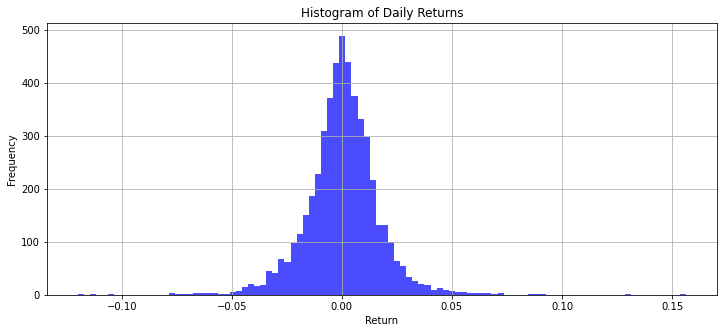

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

%md
* Most daily returns are small, the stock doesnt usually change much in one day
* There are occasional negative or positive returns - these can represent volatile days or extreme events like 2008 market crash or COVID in 2020
* Symmetric shape which suggest that returns are normally distributed

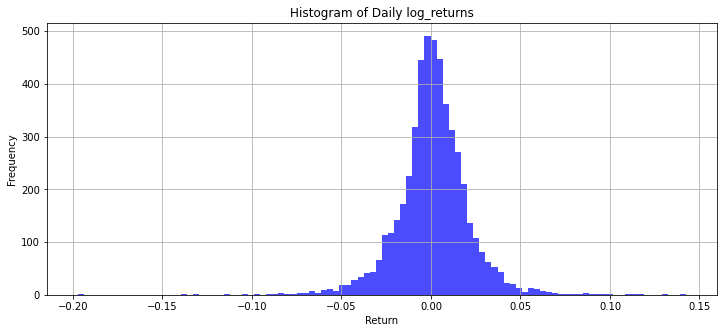

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['log_return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily log_returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

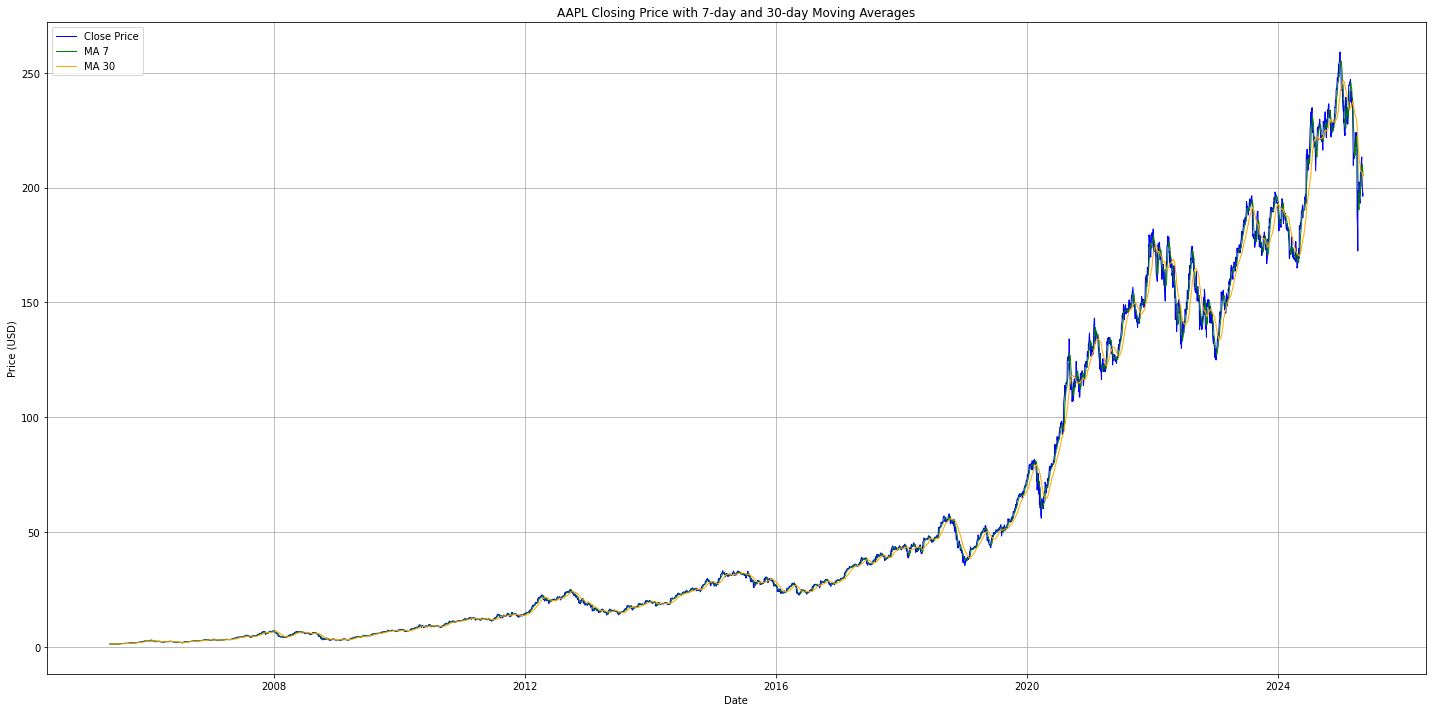

In [0]:
plt.figure(figsize=(20, 10))
plt.plot(pandas_df['Date'], pandas_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_30'],label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

%md
* Apple’s closing price has increased dramatically
* When ma_7 crosses above ma_30, it's a bullish signal (uptrend forming). When it crosses below, it's bearish (downtrend forming)
* Sharp rises or drops in the price line suggest high volatility, especially visible before and after COVID in 2020 and in recent market corrections.

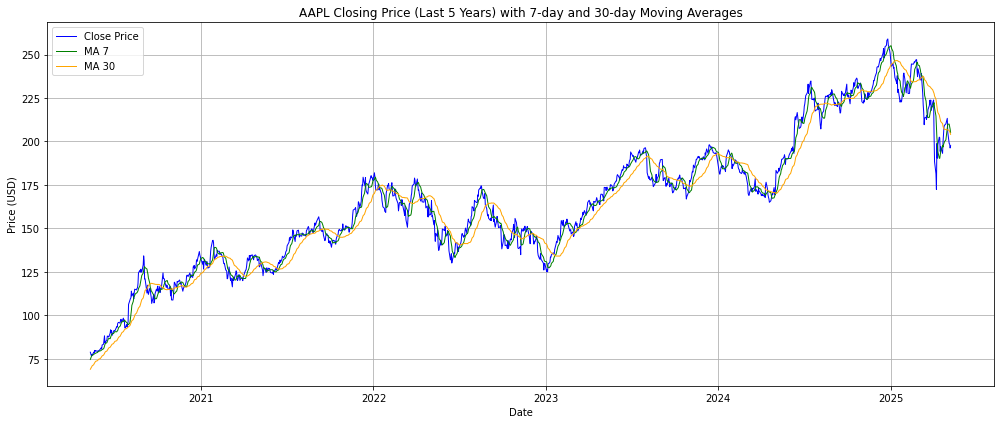

In [0]:
# Filter last 5 years only
cutoff_date = pandas_df['Date'].max() - pd.Timedelta(days=365*5)
plot_df = pandas_df[pandas_df['Date'] >= cutoff_date]

plt.figure(figsize=(14, 6))
plt.plot(plot_df['Date'], plot_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_30'], label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price (Last 5 Years) with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

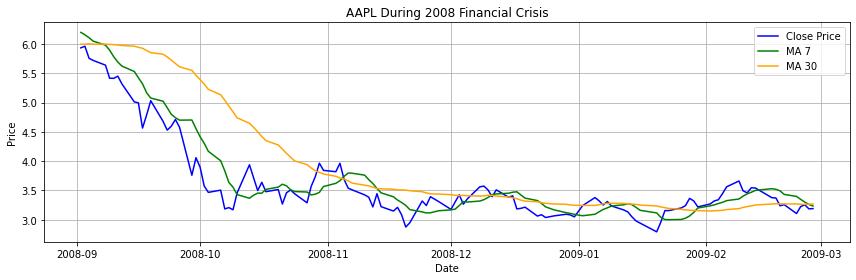

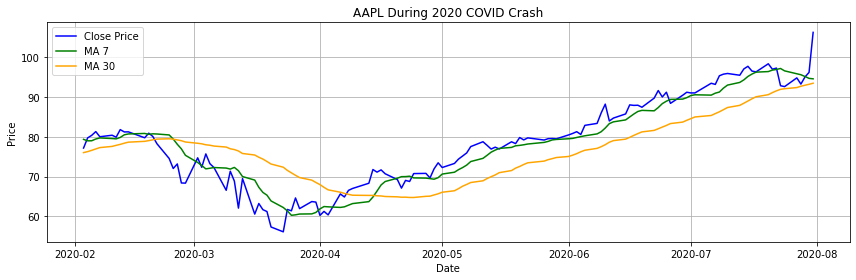

In [0]:
for label, start, end in [
    ("2008 Financial Crisis", "2008-09-01", "2009-03-01"),
    ("2020 COVID Crash", "2020-02-01", "2020-08-01")
]:
    zoom_df = pandas_df[(pandas_df['Date'] >= start) & (pandas_df['Date'] <= end)]
    plt.figure(figsize=(12, 4))
    plt.plot(zoom_df['Date'], zoom_df['close'], label='Close Price', color='blue')
    plt.plot(zoom_df['Date'], zoom_df['ma_7'], label='MA 7', color='green')
    plt.plot(zoom_df['Date'], zoom_df['ma_30'], label='MA 30', color='orange')
    plt.title(f'AAPL During {label}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 

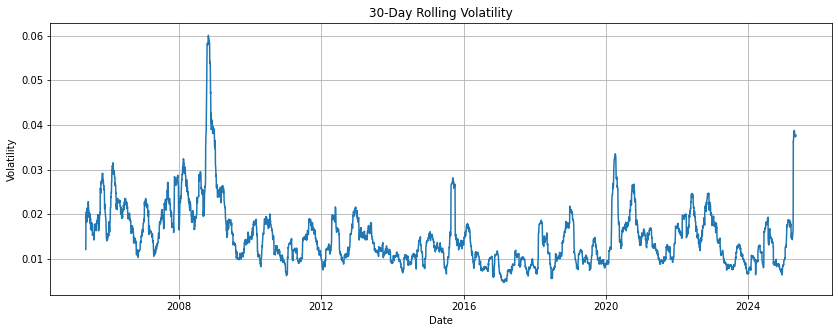

In [0]:
# --- Plot volatility with event annotations ---
plt.figure(figsize=(14, 5))
plt.plot(pandas_df['Date'], pandas_df['volatility_30'])
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

* Spikes in Volatility corresponds to market crises — 2008 financial crash, COVID crash. This is when market risk and investor uncertainty were extremely high
* Recurring smaller spikes - Could represent earnings reports, product launches, macroeconomic shocks, etc.

---------------------
From here Josh's Feature Engineering: 


In [0]:
spark_df

Out[80]: DataFrame[Date: timestamp, open: double, high: double, low: double, close: double, volume: bigint, return: double, log_return: double, volatility_30: double, ma_7: double, ma_30: double, volume_ma_7: double, close_lag_1: double, close_lag_2: double, close_lag_3: double, NextDayClose: double]

In [0]:
pandas_df.head(20)

,Date,close,return,ma_7,ma_30,volatility_30,log_return
0,2005-05-19,1.341071,0.048883,1.270833,1.270833,0.012081,0.046609
1,2005-05-20,1.341071,0.008054,1.288393,1.288393,0.019678,0.000000
2,2005-05-23,1.420000,0.050462,1.298929,1.298929,0.018362,0.057188
3,2005-05-24,1.417857,0.006337,1.319107,1.319107,0.020531,-0.001510
4,2005-05-25,1.420714,0.007089,1.333214,1.333214,0.020068,0.002013
5,2005-05-26,1.455000,0.017864,1.354796,1.344152,0.019372,0.023846
6,2005-05-27,1.448571,-0.001969,1.382245,1.356468,0.018145,-0.004428
7,2005-05-31,1.419975,-0.022152,1.406327,1.365679,0.018506,-0.019939
8,2005-06-01,1.439286,0.010278,1.417598,1.370615,0.021346,0.013508
9,2005-06-02,1.430000,-0.000250,1.431629,1.376337,0.020389,-0.006473


-------
Add Trend Indicators
 
Simple Moving Average (SMA)
 
Exponential Moving Average (EMA)
 
Hull Moving Average (HMA)

The window size in moving averages defines how many past data points are used to calculate each value of the average. Choosing the right window size depends on the trading strategy, time horizon, and market volatility you're analyzing.

| Window Size                  | Effect                                                                                               |
| ---------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Small (e.g. 5, 10)**       | Follows the price closely, **captures short-term trends**, but is more sensitive to noise.           |
| **Medium (e.g. 14, 20)**     | A balance between smoothness and responsiveness. Common in many trading strategies.                  |
| **Large (e.g. 30, 50, 200)** | Smoother curves, **better for long-term trend analysis**, but lags more behind recent price changes. |


In [0]:
# Define window size
sma_window = 14
ema_window = 14
hma_window = 14

# Define window specs
window_spec = Window.orderBy("Date").rowsBetween(-(sma_window - 1), 0)


SMA

In [0]:
spark_df = spark_df.withColumn(f"SMA_{sma_window}", avg("close").over(window_spec))


EMA

In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf("double", PandasUDFType.SCALAR)
def ema_udf(close: pd.Series) -> pd.Series:
    return close.ewm(span=ema_window, adjust=False).mean()

spark_df = spark_df.withColumn(f"EMA_{ema_window}", ema_udf(col("close")))


/databricks/spark/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


HMA

HMA(n) = WMA(2 * WMA(n/2) − WMA(n)), sqrt(n)


Firs convert spark_df to panda_df

In [0]:
panda_df = spark_df.select("Date", "close").orderBy("Date").toPandas()

In [0]:
# Weighted Moving Average (WMA) Function
def weighted_moving_average(series: pd.Series, window: int) -> pd.Series:
    weights = np.arange(1, window + 1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights[-len(x):]) / weights[-len(x):].sum(), raw=True)


In [0]:
import numpy as np

n = 14
wma_half = weighted_moving_average(panda_df["close"], int(n / 2))
wma_full = weighted_moving_average(panda_df["close"], n)

hma_intermediate = 2 * wma_half - wma_full
hma = weighted_moving_average(hma_intermediate, int(np.sqrt(n)))

# Add to DataFrame
panda_df[f"HMA_{n}"] = hma


In [0]:
print(panda_df[[ "Date", "close", f"HMA_{n}" ]].tail())


           Date   close      HMA_14
5020 2025-05-02  205.35  214.058357
5021 2025-05-05  198.89  211.033944
5022 2025-05-06  198.51  206.864222
5023 2025-05-07  196.25  202.422992
5024 2025-05-08  197.49  198.767151


In [0]:
import matplotlib.pyplot as plt

def plot_moving_averages(df, date_col="Date", price_col="close", ma_cols=None, title="Stock Price with Moving Averages", figsize=(14, 6)):
    """
    Plots the stock closing price along with selected moving averages.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - date_col: Name of the datetime column.
    - price_col: Name of the column with stock prices.
    - ma_cols: List of column names for moving averages to plot.
    - title: Title of the plot.
    - figsize: Tuple defining the size of the figure.
    """
    if ma_cols is None:
        ma_cols = [col for col in df.columns if "MA" in col or "ma" in col]
    
    plt.figure(figsize=figsize)
    plt.plot(df[date_col], df[price_col], label="Close Price", linewidth=1.5, alpha=0.7)

    for col in ma_cols:
        if col in df.columns:
            plt.plot(df[date_col], df[col], label=col, linewidth=2)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plot the results 

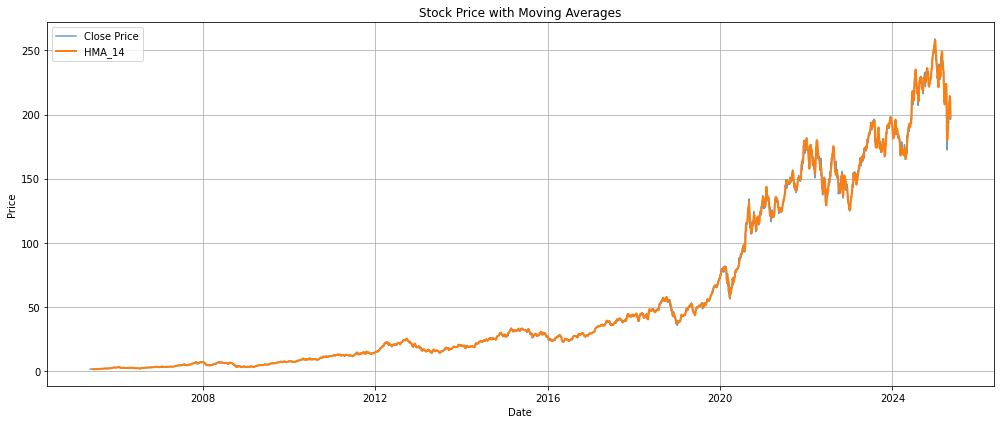

In [0]:
plot_moving_averages(panda_df, ma_cols=["SMA_14", "EMA_14", "HMA_14"])
